# Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from scipy.integrate import solve_ivp
from sklearn.cluster import KMeans

# Utils functions

In [3]:
def traj_computation(epsilon,a,b,Iext,theta,T,dt,v0,w0,percentage=0,plot=1):
  def F(x):
    v,w = x
    dv  = v - (v**3)/3 - w + Iext
    dw  = epsilon*(v + a - b*w)
    return np.array([dv,dw])

  def J(x):
    v,w = x
    J11 = 1 - theta*dt*(1-v**2)
    J12 = dt*theta
    J21 = -dt*theta*epsilon
    J22 = 1 + dt*theta*b*epsilon
    return np.array([[J11,J12],[J21,J22]])

  def Newton(x,f,maxit,tol):
    i = 0
    converged = False
    x_old = x.copy()

    def g(x_current):
      return x_current - f(x_current)

    while not converged:
      i += 1
      Jacobian_g = J(x_old)
      delta_x = np.linalg.solve(Jacobian_g, -g(x_old))
      x_new = x_old + delta_x
      if i >= maxit or np.linalg.norm(g(x_new)) < tol or np.linalg.norm(delta_x) < tol:
          converged = True
      else:
          x_old = x_new.copy()

    return x_new

  tt    = np.arange(0,T,dt)
  x     = np.array([v0,w0])

  x_old = x.copy()
  for t in tt[1:]:
    C = x_old + dt*(1-theta)*F(x_old)
    def RHS(x):
      return C + dt*theta*F(x)
    x_new = Newton(x_old,RHS,10,1e-7)
    x = np.vstack((x,x_new))
    x_old = x_new.copy()

  if plot == 1:
    plt.figure(figsize=(5, 3))
    plt.plot(tt, x[:, 0], label='v', color='c')
    plt.plot(tt, x[:, 1], label='w', color='y')
    v_plot = np.min(x[:,0]) + percentage*(np.max(x[:,0]) - np.min(x[:,0]))
    w_plot = np.min(x[:,1]) + percentage*(np.max(x[:,1]) - np.min(x[:,1]))
    plt.hlines(v_plot, xmin=0, xmax=T, color='c', linestyles='dashed', label='v_plot')
    plt.hlines(w_plot, xmin=0, xmax=T, color='y', linestyles='dashed', label='w_plot')
    plt.xlabel('Time (tt)')
    plt.ylabel('Values (v, w)')
    plt.title('Plot of v and w against Time')
    plt.legend()
    plt.grid(True)
    plt.show()

  return x

def traj_gen(epsilon,a,b,Iext,T,dt,v0,w0):
    
	def fhn(t, y, eps, a, b, I):
			v, w = y
			dvdt = v - (v**3)/3 - w + I
			dwdt = eps*(v + a - b*w)
			return [dvdt, dwdt]

	t_span = (0,T)
	t_eval = np.arange(0, T, dt)
	sol    = solve_ivp(fhn,t_span,[v0,w0],args=(epsilon, a, b, Iext),method='BDF',t_eval=t_eval)

	t = sol.t
	v = sol.y[0]
	w = sol.y[1]

	return t,v,w

def check_limit_cycle(trajectory, percentage):
	check_v = np.min(trajectory[:,0]) + percentage*(np.max(trajectory[:,0]) - np.min(trajectory[:,0]))
	check_w = np.min(trajectory[:,1]) + percentage*(np.max(trajectory[:,1]) - np.min(trajectory[:,1]))

	bool_v = trajectory[0,0] > check_v
	bool_w = trajectory[0,1] > check_w
	num_v   = 0
	num_w   = 0

	for i in range(trajectory.shape[0]):
		if (trajectory[i,0] > check_v) != bool_v:
			bool_v = not bool_v
			num_v += 1
		if (trajectory[i,1] > check_w) != bool_w:
			bool_w = not bool_w
			num_w += 1
  
	if num_v > 3 and num_w > 3:
		return True, num_v, num_w
	else:
		return False, num_v, num_w
    
def extract_persistence(trajectory):
	out = [0.0, 0.0]
	dgm = ripser(trajectory)['dgms']

	temp = dgm[0]
	temp = temp[:,1] - temp[:,0]
	temp.sort()
	out[0] = temp[-2]

	temp = dgm[1]
	temp = temp[:,1] - temp[:,0]
	temp.sort()
	if temp.shape[0] > 0:
		out[1] = temp[-1]
	else:
		out[1] = 0
			
	return out

def plot_trajectory(trajectory,tt,percentage,plotline):
	plt.figure(figsize=(5, 3))
	plt.plot(tt,trajectory[:, 0], label='v(t)', color='c')
	plt.plot(tt,trajectory[:, 1], label='w(t)', color='y')
	if plotline:
		check_v = np.min(trajectory[:,0]) + percentage*(np.max(trajectory[:,0]) - np.min(trajectory[:,0]))
		check_w = np.min(trajectory[:,1]) + percentage*(np.max(trajectory[:,1]) - np.min(trajectory[:,1]))
		plt.hlines(y=check_v, xmin=tt[0], xmax=tt[-1], colors='c', linestyles='dashed', label='v threshold')
		plt.hlines(y=check_w, xmin=tt[0], xmax=tt[-1], colors='y', linestyles='dashed', label='w threshold')
	plt.xlabel('Time')
	plt.ylabel('Values (v, w)')
	plt.title('v and w over time')
	plt.legend()
	plt.grid(True)
	plt.show()

def compute_APR(trajectory, K=10):
	s   = trajectory - trajectory.mean()
	acf = np.correlate(s, s, mode='full')
	acf = acf[len(s)-1:]
	R0  = acf[0]
	if R0 == 0:
		return 0

	acf_no0      = acf[1:]
	M            = len(acf_no0)
	seg_len      = M // K
	block_scores = []

	for j in range(K):
			seg = acf_no0[j*seg_len:(j+1)*seg_len]
			if len(seg) == 0:
					block_scores.append(0.0)
					continue
			R1_block = np.max(seg)
			block_scores.append(R1_block / R0)

	APR_avg = float(np.mean(block_scores))
	return APR_avg

# Epsilon

Il parametro epsilon influenza il periodo delle oscillazioni: aumentando epsilon la frequenza aumenta fino a un certo valore limite (che dipende dagli altri parametri, in questa configurazione è 1.1631578947368422), oltre il quale le traiettorie non presentano più cicli limite

In [ ]:
theta = 1
T     = 100
N     = 1000
dt    = T/N
NT    = 10

a       = 0.7
b       = 0.8
Iext    = 0.9
v0      = 1.5
w0      = v0

epsilon = np.linspace(0.01,1,NT)

for i in range(1,NT+1):
	print("Epsilon = ",epsilon[i-1])
	x_temp = traj_computation(epsilon[i-1],a,b,Iext,theta,T,dt,v0,w0,1)

In [ ]:
epsilon = np.linspace(1.1,1.4,NT)

for i in range(1,NT+1):
	print("Epsilon = ",epsilon[i-1])
	x_temp = traj_computation(epsilon[i-1],a,b,Iext,theta,T,dt,v0,w0,1)

# a

Il parametro a influenza la presenza di cicli limite. Con questa configurazione di parametri, l'intervallo in cui compaiono cicli limite è (0.2814285714285714, 1.1591836734693877)

In [ ]:
theta = 1
T     = 100
N     = 1000
dt    = T/N
NT    = 10

epsilon = 1/12.5
b       = 0.8
Iext    = 0.9
v0      = 1.5
w0      = v0

a = np.linspace(0.1,1.4,NT)

for i in range(1,NT+1):
	print("a = ",a[i-1])
	x_temp = traj_computation(epsilon,a[i-1],b,Iext,theta,T,dt,v0,w0,1)

È interessante notare le traiettorie diverse che si generano per valori di a compresi nell'intervallo (0.2724489795918367, 0.2814285714285714)

In [ ]:
a = np.linspace(0.265,0.29,NT)

for i in range(1,NT+1):
	print("a = ",a[i-1])
	x_temp = traj_computation(epsilon,a[i-1],b,Iext,theta,T,dt,v0,w0,1)

# b

Il parametro b influenza la presenza di cicli limite nell'intervallo (0, 1.0643434343434344) con questa configurazione di parametri

In [ ]:
theta = 1
T     = 100
N     = 1000
dt    = T/N
NT    = 10

epsilon = 1/12.5
a       = 0.7
Iext    = 0.9
v0      = 1.5
w0      = v0

b = np.linspace(0.1,1.4,NT)

for i in range(1,NT+1):
	print("b = ",b[i-1])
	x_temp = traj_computation(epsilon,a,b[i-1],Iext,theta,T,dt,v0,w0,1)

Anche per il parametro b si verifica lo stesso fenomeno del parametro a nell'intervallo (1.0643434343434344, 1.0694949494949495)

In [ ]:
b = np.linspace(1.05,1.07,NT)

for i in range(1,NT+1):
	print("b = ",b[i-1])
	x_temp = traj_computation(epsilon,a,b[i-1],Iext,theta,T,dt,v0,w0,1)

# Iext

Il valore di Iext causa la presenza di cicli limite nell'intervallo (0.32654041424344454, 1.426842105263158)

In [ ]:
theta = 1
T     = 100
N     = 1000
dt    = T/N
NT    = 20

epsilon = 1/12.5
a       = 0.7
b       = 0.8
v0      = 1.5
w0      = v0

Iext = np.linspace(0.2,2,NT)

for i in range(1,NT+1):
	print("Iext = ",Iext[i-1])
	x_temp = traj_computation(epsilon,a,b,Iext[i-1],theta,T,dt,v0,w0,1)

# Trajectories examples

In [ ]:
theta = 1
T     = 100
N     = 1000
dt    = T/N
NT    = 10

percentage = 0.6

v0      = 1.5
w0      = v0

total_trajectories       = 0
limit_cycle_trajectories = 0

trajectories = []

for i in range(1,NT+1):
	epsilon = np.random.uniform(0.0,1.2)
	a       = np.random.uniform(0.1,1.0)
	b       = np.random.uniform(0.1,1.0)
	Iext    = np.random.uniform(0.2,1.4)

	#print("Epsilon = ",epsilon,", a = ",a,", b = ",b,", Iext = ",Iext)
	x_temp = traj_computation(epsilon,a,b,Iext,theta,T,dt,v0,w0,0)
	trajectories.append(x_temp)
	total_trajectories += 1
	if check_limit_cycle(x_temp, percentage):
		limit_cycle_trajectories += 1

training_target = np.stack(trajectories, axis=0).astype(np.float64)
print("Percentage of limit cycle trajectories: ",(limit_cycle_trajectories/total_trajectories)*100,"%")

# Choosing the right limit cycle checker

### Accuracy testing (depending on dt)

In [ ]:
np.random.seed(0)
theta = 1
T     = 100
N     = 100
dt    = T/N
NT    = 500

percentage = 0.5

v0 = 1.5
w0 = v0

limit_cycle_trajectories = 0

trajectories = []
bools_tt     = []

upper_limit = 1

for i in range(NT):
	epsilon = np.random.uniform(0.0,upper_limit)
	a       = np.random.uniform(0.1,upper_limit)
	b       = np.random.uniform(0.1,upper_limit)
	Iext    = np.random.uniform(0.2,upper_limit)

	tt,v,w = traj_gen(epsilon,a,b,Iext,T,dt,v0,w0)
	x_temp = np.hstack((v.reshape(-1,1),w.reshape(-1,1)))
	trajectories.append(x_temp)
	check, num_v, num_w = check_limit_cycle(x_temp,percentage)
	bools_tt.append(check)
	if i % 100 == 0:
		plot_trajectory(x_temp,tt,percentage,True)
		print("Number of crossings for v: ", num_v, " and for w: ", num_w)
		print("Parameters: epsilon = ",epsilon,", a = ",a,", b = ",b,", Iext = ",Iext)
	if check:
		limit_cycle_trajectories += 1


training_target_solver = np.stack(trajectories, axis=0).astype(np.float64)
print("Percentage of limit cycle trajectories: ",(limit_cycle_trajectories/NT)*100,"%")

In [ ]:
np.random.seed(0)
theta = 1
T     = 100
N     = 100
dt    = T/N
NT    = 500

percentage = 0.5

v0 = 1.5
w0 = v0

limit_cycle_trajectories = 0

trajectories = []
bools_100    = []

upper_limit = 1

for i in range(NT):
	epsilon = np.random.uniform(0.0,upper_limit)
	a       = np.random.uniform(0.1,upper_limit)
	b       = np.random.uniform(0.1,upper_limit)
	Iext    = np.random.uniform(0.2,upper_limit)

	x_temp = traj_computation(epsilon,a,b,Iext,theta,T,dt,v0,w0,percentage,0)
	trajectories.append(x_temp)
	check, num_v, num_w = check_limit_cycle(x_temp,percentage)
	bools_100.append(check)
	if i % 100 == 0:
		plot_trajectory(x_temp,0,T,percentage,True)
		print("Number of crossings for v: ", num_v, " and for w: ", num_w)
		print("Parameters: epsilon = ",epsilon,", a = ",a,", b = ",b,", Iext = ",Iext)
	if check:
		limit_cycle_trajectories += 1


training_target_100 = np.stack(trajectories, axis=0).astype(np.float64)
print("Percentage of limit cycle trajectories: ",(limit_cycle_trajectories/NT)*100,"%")

In [ ]:
np.random.seed(0)
theta = 1
T     = 100
N     = 1000
dt    = T/N
NT    = 500

percentage = 0.5

v0 = 1.5
w0 = v0

limit_cycle_trajectories = 0

trajectories = []
bools_1000   = []

upper_limit = 1

for i in range(NT):
	epsilon = np.random.uniform(0.0,upper_limit)
	a       = np.random.uniform(0.1,upper_limit)
	b       = np.random.uniform(0.1,upper_limit)
	Iext    = np.random.uniform(0.2,upper_limit)

	x_temp = traj_computation(epsilon,a,b,Iext,theta,T,dt,v0,w0,percentage,0)
	trajectories.append(x_temp)
	check, num_v, num_w = check_limit_cycle(x_temp,percentage)
	bools_1000.append(check)
	if i % 100 == 0:
		plot_trajectory(x_temp,0,T,percentage,True)
		print("Number of crossings for v: ", num_v, " and for w: ", num_w)
		print("Parameters: epsilon = ",epsilon,", a = ",a,", b = ",b,", Iext = ",Iext)
	if check:
		limit_cycle_trajectories += 1


training_target_1000 = np.stack(trajectories, axis=0).astype(np.float64)
print("Percentage of limit cycle trajectories: ",(limit_cycle_trajectories/NT)*100,"%")

In [ ]:
np.random.seed(0)
theta = 1
T     = 100
N     = 10000
dt    = T/N
NT    = 500

percentage = 0.5

v0 = 1.5
w0 = v0

limit_cycle_trajectories = 0

trajectories = []
bools_10000  = []

upper_limit = 1

for i in range(NT):
	epsilon = np.random.uniform(0.0,upper_limit)
	a       = np.random.uniform(0.1,upper_limit)
	b       = np.random.uniform(0.1,upper_limit)
	Iext    = np.random.uniform(0.2,upper_limit)

	x_temp = traj_computation(epsilon,a,b,Iext,theta,T,dt,v0,w0,percentage,0)
	trajectories.append(x_temp)
	check, num_v, num_w = check_limit_cycle(x_temp,percentage)
	bools_10000.append(check)
	if i % 100 == 0:
		plot_trajectory(x_temp,0,T,percentage,True)
		print("Number of crossings for v: ", num_v, " and for w: ", num_w)
		print("Parameters: epsilon = ",epsilon,", a = ",a,", b = ",b,", Iext = ",Iext)
	if check:
		limit_cycle_trajectories += 1


training_target_10000 = np.stack(trajectories, axis=0).astype(np.float64)
print("Percentage of limit cycle trajectories: ",(limit_cycle_trajectories/NT)*100,"%")

In [ ]:
checks = [i!=j for i,j in zip(bools_100,bools_1000)]

for i in range(NT):
	if checks[i]:
		fig, ax = plt.subplots(1,4, figsize=(15, 5))
		ax[0].plot(np.arange(0,T,T/100),training_target_100[i,:,0])
		ax[0].plot(np.arange(0,T,T/100),training_target_100[i,:,1])
		ax[1].plot(np.arange(0,T,T/1000),training_target_1000[i,:,0])
		ax[1].plot(np.arange(0,T,T/1000),training_target_1000[i,:,1])
		ax[2].plot(np.arange(0,T,T/10000),training_target_10000[i,:,0])
		ax[2].plot(np.arange(0,T,T/10000),training_target_10000[i,:,1])
		ax[3].plot(np.arange(0,T,T/100),training_target_solver[i,:,0])
		ax[3].plot(np.arange(0,T,T/100),training_target_solver[i,:,1])


### Accuracy of limit cycle checker

In [ ]:
np.random.seed(0)
theta = 1
T     = 100
N     = 100
dt    = T/N
NT    = 500

percentage = 0.5

v0 = 1.5
w0 = v0

limit_cycle_trajectories = 0

trajectories = []

upper_limit = 1.5

for i in range(NT):
	epsilon = np.random.uniform(0.0,upper_limit)
	a       = np.random.uniform(0.1,upper_limit)
	b       = np.random.uniform(0.1,upper_limit)
	Iext    = np.random.uniform(0.2,upper_limit)

	tt,v,w = traj_gen(epsilon,a,b,Iext,T,dt,v0,w0)
	x_temp = np.hstack((v.reshape(-1,1),w.reshape(-1,1)))
	trajectories.append(x_temp)
	check, num_v, num_w = check_limit_cycle(x_temp,percentage)
	if i % 10 == 0:
		plot_trajectory(x_temp,tt,percentage,True)
		print("Number of crossings for v: ", num_v, " and for w: ", num_w)
		print("Limit cycle check: ", check)
	if check:
		limit_cycle_trajectories += 1


training_target = np.stack(trajectories, axis=0).astype(np.float64)
print("Percentage of limit cycle trajectories: ",(limit_cycle_trajectories/NT)*100,"%")

### Testing APR (Autocorrelation Peak Ratio) as limit cycle checker

In [ ]:
np.random.seed(0)
theta = 1
T     = 100
N     = 100
dt    = T/N
NT    = 500

percentage = 0.5

v0 = 1.5
w0 = v0

trajectories = []
APR          = []

upper_limit = 1

for i in range(NT):
	epsilon = np.random.uniform(0.0,upper_limit)
	a       = np.random.uniform(0.1,upper_limit)
	b       = np.random.uniform(0.1,upper_limit)
	Iext    = np.random.uniform(0.2,upper_limit)

	tt,v,w = traj_gen(epsilon,a,b,Iext,T,dt,v0,w0)
	v_APR = compute_APR(v,5)
	w_APR = compute_APR(w,5)
	APR.append(np.hstack((v_APR, w_APR)))
	x_temp = np.hstack((v.reshape(-1,1),w.reshape(-1,1)))
	trajectories.append(x_temp)


training_target = np.stack(trajectories, axis=0).astype(np.float64)

APR    = np.array(APR)
plt.plot(APR[:,0], APR[:,1], 'o')

In [ ]:
kmeans = KMeans(n_clusters=2, max_iter=10000, tol=1e-8, random_state=0, n_init="auto").fit(APR)

percentage1 = sum(kmeans.labels_)/len(kmeans.labels_)*100
percentage2 = 100 - percentage1

print("Cluster 1 percentage: ", percentage1,"%")
print("Cluster 2 percentage: ", percentage2,"%")

for i in range(1):
	plot_trajectory(training_target[i,:,:],tt,0,0)
	print('APR: ', APR[i,:] ,'KMeans prediction: ', kmeans.labels_[i])

### Testing APR and FFT as limit cycle checker

In [ ]:
np.random.seed(0)
theta = 1
T     = 100
N     = 100
dt    = T/N
NT    = 500

percentage = 0.5

v0 = 1.5
w0 = v0

trajectories = []
APR          = []
frequences   = []

upper_limit = 1.5

for i in range(NT):
	epsilon = np.random.uniform(0.0,upper_limit)
	a       = np.random.uniform(0.1,upper_limit)
	b       = np.random.uniform(0.1,upper_limit)
	Iext    = np.random.uniform(0.2,upper_limit)

	tt,v,w = traj_gen(epsilon,a,b,Iext,T,dt,v0,w0)
	v_APR = compute_APR(v,5)
	w_APR = compute_APR(w,5)
	APR.append(np.hstack((v_APR, w_APR)))

	v_norm = (v - v.mean()) / v.std()
	w_norm = (w - w.mean()) / w.std()
	sv = np.fft.rfft(v_norm)
	fv = np.fft.rfftfreq(len(v_norm), dt)
	av = np.abs(sv)
	sw = np.fft.rfft(w_norm)
	fw = np.fft.rfftfreq(len(w_norm), dt)
	aw = np.abs(sw)
	frequences.append(np.hstack((fv[np.argmax(av)],fw[np.argmax(aw)])))
	
	x_temp = np.hstack((v.reshape(-1,1),w.reshape(-1,1)))
	trajectories.append(x_temp)


training_target = np.stack(trajectories, axis=0).astype(np.float64)

In [ ]:
APR        = np.array(APR)
frequences = np.array(frequences)
covariates = np.hstack((APR,frequences))

kmeans = KMeans(n_clusters=2, max_iter=10000, tol=1e-8, random_state=0, n_init="auto").fit(covariates)

percentage1 = sum(kmeans.labels_)/len(kmeans.labels_)*100
percentage2 = 100 - percentage1

print("Cluster 1 percentage: ", percentage1,"%")
print("Cluster 2 percentage: ", percentage2,"%")

for i in range(1):
	plot_trajectory(training_target[i,:,:],tt,0,0)
	print('APR: ', APR[i,:],'Frequences: ', frequences[i,:] ,'KMeans prediction: ', kmeans.labels_[i])

# Percentage estimation

We are now testing how changing the interval of the parameters has an influence on the percentage of limit cycles in the dataset. We recall that the intervals of sampling are:

- epsilon: (0.0, upper_limit)
- a:       (0.1, upper_limit)
- b:       (0.1, upper_limit)
- Iext:    (0.2, upper_limit)

In [8]:
np.random.seed(0)
T     = 100
N     = 100
dt    = T/N
NT    = 500

percentage = 0.5

v0 = 1.5
w0 = v0

lct   = 0
APR   = []
trajs = []

upper_limit = 0.8

for i in range(NT):
	epsilon = np.random.uniform(0.0,upper_limit)
	a       = np.random.uniform(0.1,upper_limit)
	b       = np.random.uniform(0.1,upper_limit)
	Iext    = np.random.uniform(0.2,upper_limit)

	tt,v,w = traj_gen(epsilon,a,b,Iext,T,dt,v0,w0)
	v_APR  = compute_APR(v,5)
	w_APR  = compute_APR(w,5)
	x_temp = np.hstack((v.reshape(-1,1),w.reshape(-1,1)))
	trajs.append(x_temp)
	APR.append(np.hstack((v_APR, w_APR)))
	check, num_v, num_w = check_limit_cycle(x_temp,percentage)
	if check:
		lct += 1

trajectories = np.stack(trajs, axis=0).astype(np.float64)

APR         = np.array(APR)
kmeans      = KMeans(n_clusters=2, max_iter=10000, tol=1e-8, random_state=0, n_init="auto").fit(APR)
percentage1 = sum(kmeans.labels_)/len(kmeans.labels_)*100
percentage0 = 100 - percentage1

if APR[kmeans.labels_ == 1][0,0] < APR[kmeans.labels_ == 0][0,0]:
	print('Percentage of limit cycle trajectories (APR): ', percentage0, '%')
else:
	print('Percentage of limit cycle trajectories (APR): ', percentage1, '%')

print('Percentage of limit cycle trajectories (Standard): ',(lct/NT)*100,"%")

Percentage of limit cycle trajectories (APR):  85.2 %
Percentage of limit cycle trajectories (Standard):  86.2 %


| upper_limit | Limit Cycles percentage |
| ----------- | :---------------------: |
| 0.5         | 90.0%                   |
| 0.8         | 88.4%                   |
| 1           | 65.4%                   |
| 1.1         | 56.8%                   |
| 1.3         | 41.8%                   |
| 1.4         | 32.4%                   |
| 1.5         | 28.4%                   |
| 1.7         | 17.8%                   |
| 2.3         | 10.0%                   |

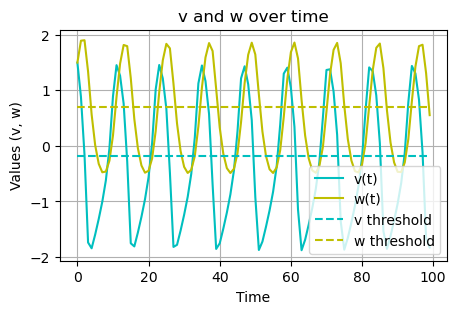

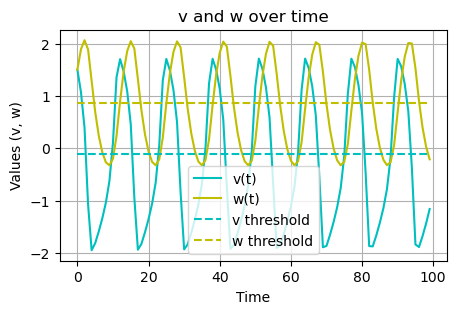

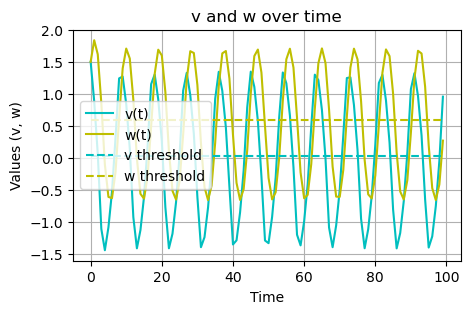

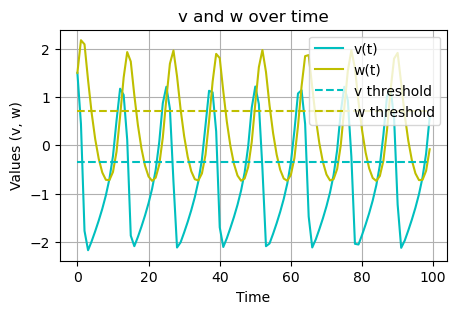

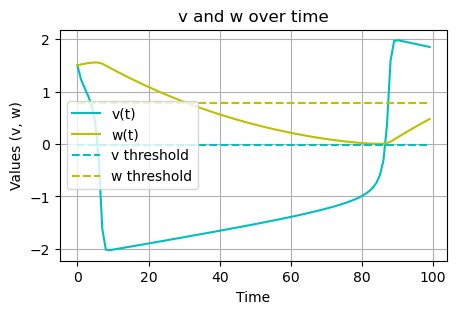

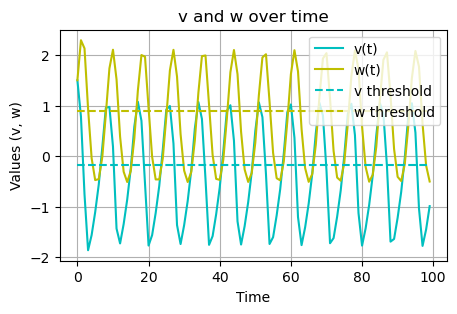

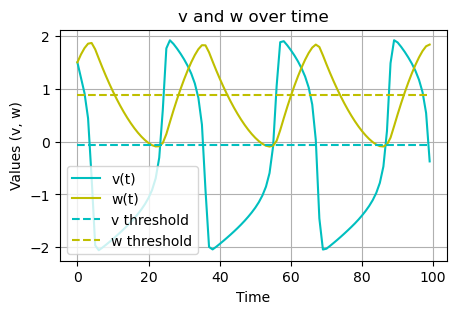

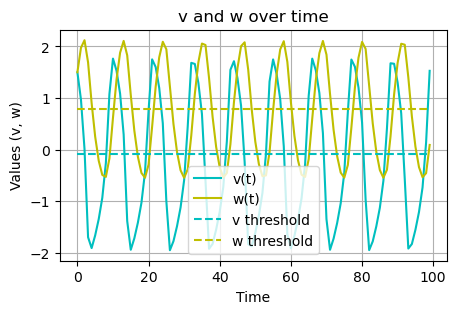

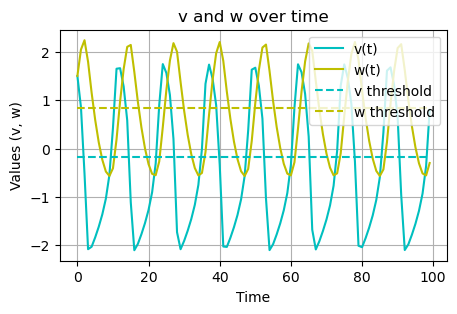

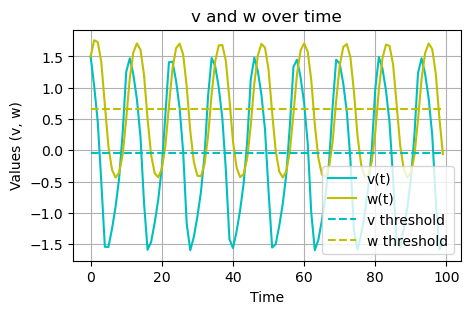

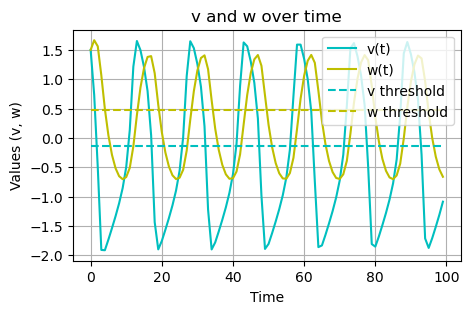

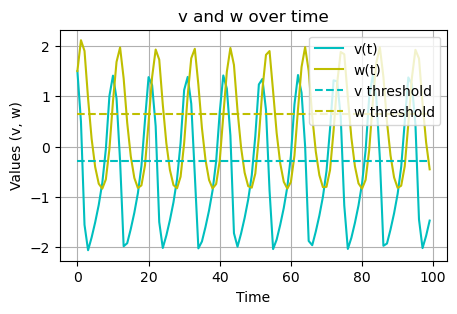

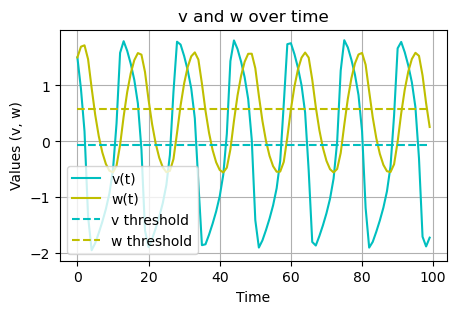

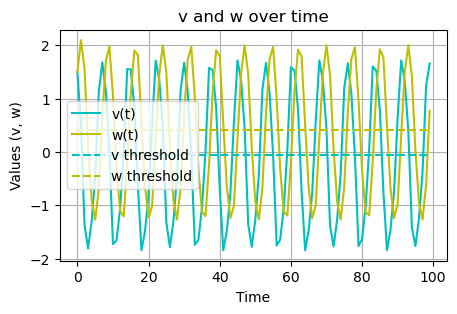

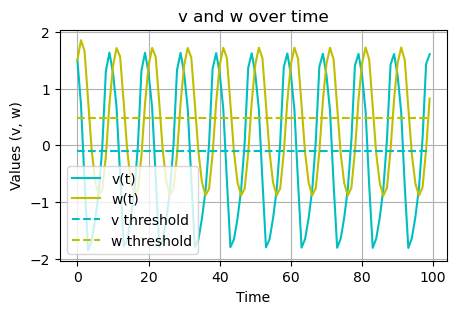

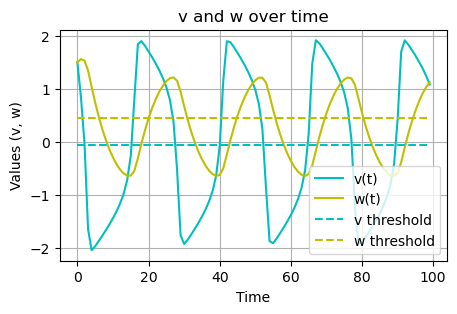

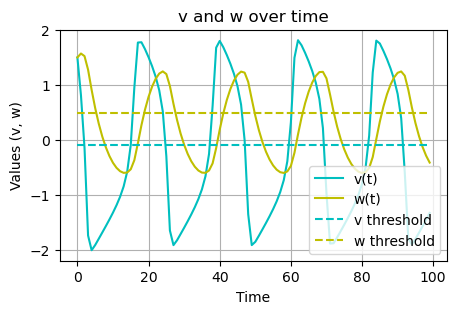

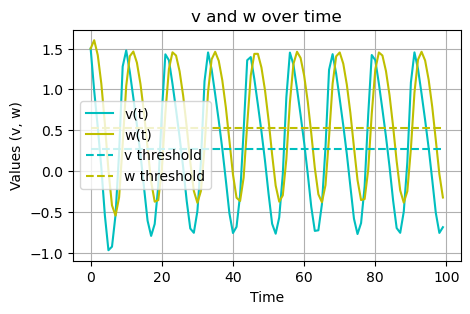

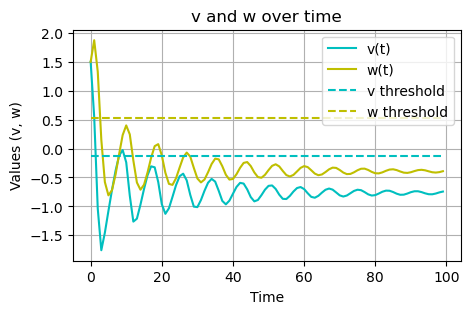

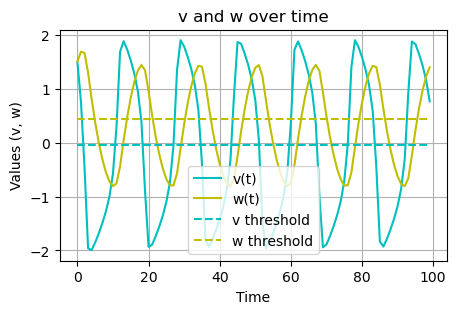

In [9]:
for i in range(20):
    plot_trajectory(trajectories[i,:,:],tt,percentage,1)